# Introduction

Hi there! In this notebook I'm performing EDA on a mall's customer dataset and then segmenting using clustering techniques.
There are no labels in the dataset so it's a good application of unsupervised learning methods.
I'm comparing K-Means, DBScan and Hierarchical Clustering. 

We perform clustering to find the number of segments that can be created and how effective / useful these segments will be 
for various purposes such as targeted advertising, traffic control, event planning and so on.

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans 
from sklearn.cluster import MiniBatchKMeans   
from sklearn.cluster import DBSCAN
from sklearn import metrics

# EDA

In [2]:
df_mall = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

Let's check the first couple of records:

In [3]:
df_mall.head(10) 

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


Let's get some basic statistics about the dataset:

In [4]:
df_mall.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Checking for null values:

In [5]:
df_mall.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Phew... No null values! Since there are no null or missing values in the dataset, we don't need to perform
feature engineering.

Based on the info() output, we can see that there are 200 customers in the dataset.

In [6]:
df_mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Let's take a look at the pair plot of customers according to their gender and see if there are any significant differences between male and female shoppers:

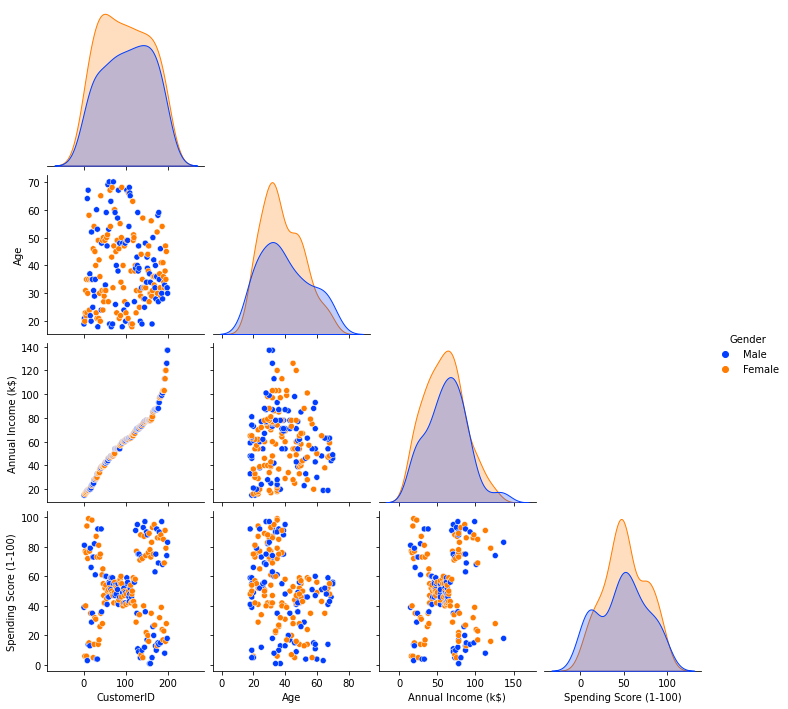

In [7]:
df_mall_copy = df_mall.copy()

# Replacing Male / Female with 1 & 0 respectively to allow us to use the Gender column.
df_mall_copy['Gender'].replace('Female', 0, inplace = True)
df_mall_copy['Gender'].replace('Male', 1, inplace = True)
sns.pairplot(data = df_mall, hue = 'Gender', corner = True, palette = 'bright')

From the above plot, we can infer that there is no significant difference based on Gender.

An interesting library I came across was the pandas_profiling library.
The ProfileReport is super handy to obtain a detailed statistical report.
It also gives us great visualisations for the dataset.

In [8]:
ProfileReport(df_mall)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# K-Means

The K-Means clustering algorithm groups the dataset into 'k' number of clusters. 
The data belonging to each cluster have similar properties. 

The 'k' value can be found in two ways: 
- WCSS (inertia) 
- Elbow Method

**Feature selection:**

I'm only extracting two columns as features: `Annual Income` and the `Spending Score`

In [9]:
feats = df_mall[['Annual Income (k$)','Spending Score (1-100)']]
feats

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


**Finding `k` using WCSS**

I'm performing 20 iterations to check which value between 1 to 20 is best fit.
As mentioned in the previous step, the groups will be created based on the annual income and the spending score.
Each cluster is created using the default k-means implementation.

In [10]:
wcss = []
for i in range(1,20):   
    km = KMeans(n_clusters = i,init = 'k-means++',random_state = 30)  
    km.fit(feats)                                                   
    wcss.append(km.inertia_)                                    

In [11]:
wcss 

[269981.28000000014,
 181363.59595959607,
 106348.37306211119,
 73679.78903948837,
 44448.45544793369,
 37233.81451071002,
 30273.394312070028,
 25079.766962115882,
 21850.16528258562,
 19787.67055496685,
 18004.8218348464,
 16372.662146832501,
 14349.754043342282,
 13408.710180900964,
 12097.942504133285,
 10757.36670233006,
 10210.711191001985,
 9257.46990745827,
 8614.395015683376]

**Finding `k` using Elbow Graph method**

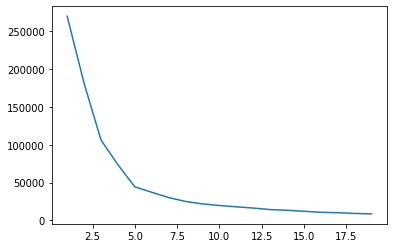

In [12]:
plt.plot(range(1, 20), wcss)  

There is a steep decline at x = 5.0, y = 50000.

I'm choosing k = 5 i.e., 5 clusters will be created.

**Building & Fitting the Model**

In [13]:
km = KMeans(n_clusters = 5, init = 'k-means++', random_state = 30)
km.fit_predict(feats)  

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0], dtype=int32)

We can see that all the rows are labelled into our 5 cluster categories, i.e, clusters 0 to 4.
Let's record all the cluster numbers as a column in the dataset:

In [14]:
feats['cluster_number'] = km.fit_predict(feats)
feats

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Annual Income (k$),Spending Score (1-100),cluster_number
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4
...,...,...,...
195,120,79,0
196,126,28,1
197,126,74,0
198,137,18,1


Let's see the points that are inside cluster 4.

In [15]:
feats[feats['cluster_number'] == 4]

,Annual Income (k$),Spending Score (1-100),cluster_number
0,15,39,4
2,16,6,4
4,17,40,4
6,18,6,4
8,19,3,4
10,19,14,4
12,20,15,4
14,20,13,4
16,21,35,4
18,23,29,4


Similarly, for cluster 0:

In [16]:
feats[feats['cluster_number'] == 0]

,Annual Income (k$),Spending Score (1-100),cluster_number
123,69,91,0
125,70,77,0
127,71,95,0
129,71,75,0
131,71,75,0
133,72,71,0
135,73,88,0
137,73,73,0
139,74,72,0
141,75,93,0


We can clearly that all data points with high spending score are in cluster 0.

Let's try predicting for annual income of $87000 and spending score of 75.

In [17]:
km.predict([[87, 75]])   

array([0], dtype=int32)

We can see that it predicted this data point to be in cluster 0 as can be observed in the table.

# K-Means + Minibatch

The minibatch algorithm splits the dataset into smaller batches and creates clusters for each batch.

**Building & Fitting the Model**

In [18]:
mini = MiniBatchKMeans(n_clusters = 5)  
mini.fit(feats[['Annual Income (k$)','Spending Score (1-100)']])

MiniBatchKMeans(n_clusters=5)

Let's try predicting with annual income of $16000 and spending score of 77:

In [19]:
#model prediction 

mini.predict([[16,77]])   

array([2], dtype=int32)

Our model has correctly predicted that the data point belongs to Cluster 4.

# DBSCAN

The DBSCAN algorithm is used to find the number of clusters along with the outliers. 

Its advantage over K-Means is that the number of clusters doesn't have to be known beforehand.
So model training can be performed even without knowing the `k` value.

**Building & Fitting the Model**

To create the DBScan model, we need to specify two important parameters:
- eps: the radius of the cluster,
- min_samples: the min number of data points within each cluster 

In [20]:
dbscan = DBSCAN(eps = 0.7,min_samples = 3)   
dbscan.fit(feats[['Annual Income (k$)','Spending Score (1-100)']])

DBSCAN(eps=0.7, min_samples=3)

**Detecting the Outliers:**

In [21]:
dbscan.labels_  

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

The -1 as output symbolizes an outlier. Since every data point is an outlier in our model, we change the radius such that clusters can be formed. 

**Building & Fitting the Model**

In [22]:
dbscan = DBSCAN(eps = 5, min_samples = 4)
dbscan.fit(feats[['Annual Income (k$)','Spending Score (1-100)']])

DBSCAN(eps=5, min_samples=4)

**Detecting the Outliers in the updated model:**

In [23]:
dbscan.labels_  

array([-1,  0, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4, -1,  2, -1,  4,  3,  2,  3,  2, -1,  2,  3,  4,
        3,  2,  3,  2,  3,  4, -1,  4,  3,  4, -1,  2,  5,  4,  5,  4,  5,
        2,  5,  4,  3,  2,  3,  2, -1,  4,  3,  4, -1, -1, -1, -1, -1, -1,
        6, -1,  6, -1,  6, -1,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

There are fewer outliers in our new model and we can see that clusters have been formed between 0 to 6. So there are 7 clusers.

Let's add the cluster info to the dataset:

In [24]:
feats_new = feats[['Annual Income (k$)','Spending Score (1-100)']]
feats_new['dbscan_cluster_name'] = dbscan.labels_   
feats_new

,Annual Income (k$),Spending Score (1-100),dbscan_cluster_name
0,15,39,-1
1,15,81,0
2,16,6,-1
3,16,77,0
4,17,40,-1
...,...,...,...
195,120,79,-1
196,126,28,-1
197,126,74,-1
198,137,18,-1


Let's take the dataset with `cluster_number` as the true values and the one with `dbscan_cluster_name` as predicted values.

**Labels**

In [25]:
yt = feats['cluster_number']
yp = feats_new['dbscan_cluster_name']  

# Metrics

**Adjusted Rand Score**

The accuracy of our model is 56%.

In [26]:
metrics.adjusted_rand_score(yt, yp)

0.5641095154835344

**Homogeneity Score**

In [27]:
metrics.homogeneity_score(yt, yp)

0.6007983436060925